In [1]:
# 모델 생성
from tensorflow.compat.v1.keras.models import Sequential, Model

# layer 네트워크 
from tensorflow.compat.v1.keras.layers import Reshape, concatenate, Activation, LeakyReLU, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda

# Optimizer
from tensorflow.compat.v1.keras.optimizers import SGD, Adam, RMSprop

# 네트워크 추가 설정 
from tensorflow.compat.v1.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# 백엔드 함수
import tensorflow.compat.v1.keras.backend as K

# tensorflow
import tensorflow.compat.v1 as tf

# Image Data Augmentation을 편하게 해주는 라이브러리
import imgaug

# 기본 라이브러리
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import cv2

# 사용자 라이브러리
from utils import WeightReader, decode_netout, draw_boxes

from preprocessing import parse_annotation, BatchGenerator

# K mean clustering
from sklearn.cluster import KMeans


In [2]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 
          'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 
          'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 
          'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 
          'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 
          'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 
          'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 
          'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
          'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 
          'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
 

CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32') # 
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45

# training setting
BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0

In [3]:
BOX              = 5 # bounding_box_machine 개수
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828] #xy*2
TRUE_BOX_BUFFER  = 50 # 이미지 안에 최대 사물 개수

In [28]:
anchor_value = []
for i in range(len(all_imgs)):
    obj = all_imgs[i]['object']
    for i in range(len(obj)):
        w = (obj[i]['xmax'] - obj[i]['xmin']/IMAGE_W)*13
        h = (obj[i]['ymax'] - obj[i]['ymin']/IMAGE_H)
        value = [w,h]
        anchor_value.append(value)
        

NameError: name 'all_imgs' is not defined

In [29]:
anchor_value

[]

In [30]:
k_mean_model = KMeans(n_clusters=5).fit(anchor_value)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [31]:
k_means = k_mean_model.cluster_centers_

NameError: name 'k_mean_model' is not defined

In [32]:
anchor_value = np.array(anchor_value)

In [33]:
plt.plot(anchor_value[:,0],anchor_value[:,1],'.')

IndexError: too many indices for array

NameError: name 'k_means' is not defined

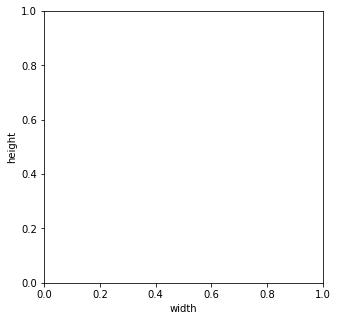

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(5,5))
plt.xlabel('width')
plt.ylabel('height')
for i in range(len(k_means)):
    plt.axes().add_patch(
        patches.Rectangle(
            (200-(k_means[i][0]/2),200-(k_means[i][1]/2)),   # (x,y)
            k_means[i][0],          # width
            k_means[i][1],          # height
            facecolor="purple",
            alpha=0.1
        )
    )
    plt.xlim([0,400])
    plt.ylim([0,400])

![](https://curt-park.github.io/images/yolo/notation.JPG)

In [4]:
NO_OBJECT_SCALE  = 1.0 # λnoobj
OBJECT_SCALE     = 5.0 # λobj
COORD_SCALE      = 1.0 # λcoord
CLASS_SCALE      = 1.0 # λclass

In [5]:
anno_path = '/Users/changmin.kim/Downloads/VOC2012/Annotations/'
image_path = '/Users/changmin.kim/Downloads/VOC2012/JPEGImages/'

all_imgs, seen_labels = parse_annotation(anno_path,image_path)
print("all_imgs:",len(all_imgs))
print("seen_labels:",len(seen_labels))

all_imgs: 17125
seen_labels: 23


In [6]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [7]:
def normalize(image):
    return image / 255.

In [8]:
train_batch = BatchGenerator(all_imgs,generator_config,norm=normalize)

/Users/changmin.kim/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [12]:
result = next(iter(train_batch))

return 배치


In [13]:
batch_image = result[0][0]
batch_true_box = result[0][1]
batch_label = result[1]

In [14]:
print("image 배치 크기:",batch_image.shape)
print("true_box 배치 크기",batch_true_box.shape)
print("label 배치 크기:",batch_label.shape)

image 배치 크기: (16, 416, 416, 3)
true_box 배치 크기 (16, 1, 1, 1, 50, 4)
label 배치 크기: (16, 13, 13, 5, 85)


In [15]:
y_pred = tf.ones((16, 13, 13, 5, 85))
y_true = result[1]
true_boxes = result[0][1]

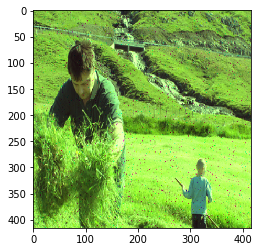

person의 인덱스는 0이므로 해당 인덱스 값인 0이 구분이 안될 수 있다.
하지만 class_mask로 분류하기 때문에 문제 되진 않는다.
label: person 

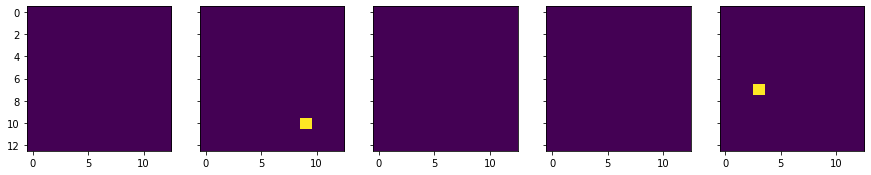

In [16]:
num = np.random.randint(0,16)

plt.imshow(batch_image[num])
plt.show()
label = np.unique(tf.argmax(y_true[...,5:],-1)[num])
print("person의 인덱스는 0이므로 해당 인덱스 값인 0이 구분이 안될 수 있다.")
print("하지만 class_mask로 분류하기 때문에 문제 되진 않는다.")
print("label:",end=" ")
for i in label:
    print(LABELS[i],end=" ")

fig, axs = plt.subplots(1, 5, figsize=(15, 10), sharey=True)
for i in range(5):
    axs[i].imshow(result[1][num][:,:,i,4]) # train_label
plt.show()

In [17]:
mask_shape = tf.shape(y_true)[:4]

cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
cell_y = tf.transpose(cell_x,[0,2,1,3,4])

cell_grid = tf.tile(tf.concat([cell_x,cell_y],-1),[BATCH_SIZE,1,1,5,1])

W1027 22:43:26.941746 4576882112 deprecation.py:323] From <ipython-input-17-db9db47ca781>:3: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


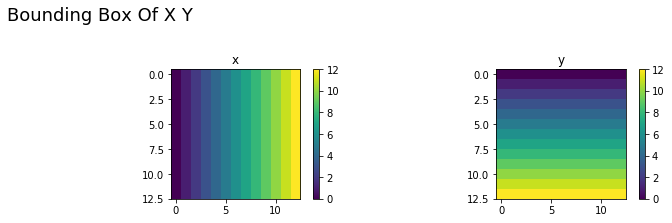

In [18]:
fig = plt.figure()           # Define "figure" instance
fig.set_size_inches(16,3)    # Physical page size in inches, (lx,ly)
suptit="Bounding Box Of X Y"
fig.suptitle(suptit,fontsize=18,y=0.99)   # Title for the page
fig.subplots_adjust(left=0.5,right=1,bottom=0.1,top=0.7,wspace=0.3,hspace=0.3)

name = ["x","y"]
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    pic1 = ax.imshow(cell_grid[0,:,:,0,i])
    plt.title(name[i])
    plt.colorbar(pic1)
plt.show()

In [19]:
coord_mask = tf.zeros(mask_shape)
conf_mask  = tf.zeros(mask_shape)
class_mask = tf.zeros(mask_shape)

In [20]:
seen = tf.Variable(0.)
total_recall = tf.Variable(0.)

픽셀 좌표에서 경계 상자의 실제 너비와 높이를 얻으려면 다음을 수행합니다. (b: 5개의 object머신)
- box_w[row, col, b] = anchor_w[b] * exp(delta_w[row, col, b]) * 32
- box_h[row, col, b] = anchor_h[b] * exp(delta_h[row, col, b]) * 32

예측값 delta_w이 0보다 작은 경우은 exp(delta_w)이 0과 1 사이의 숫자이므로 bounding_box가 anchor_box보다 작아진다. 
<br>만약 delta_w이 0보다 큰 경우, exp(delta_w)> 1의 값은 bounding_box를 크게 만든다. 
<br>그리고 delta_w이 0일 경우 bounding_box가 정확히 anchor_box와 같은 크기이다.

### Adhust prediction 

In [21]:
### adjust x and y      
pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # -> 0 ~ 13 

### adjust w and h
pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2]) # -> 0 ~ inf

### adjust confidence
pred_box_conf = tf.sigmoid(y_pred[..., 4])

### adjust class probabilities
pred_box_class = y_pred[..., 5:]

### Adjust ground truth

In [22]:
### adjust x and y
true_box_xy = y_true[..., 0:2] # relative position to the containing cell 0~13

### adjust w and h
true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically 0~inf

### adjust confidence
true_wh_half = true_box_wh / 2.
true_mins    = true_box_xy - true_wh_half
true_maxes   = true_box_xy + true_wh_half

pred_wh_half = pred_box_wh / 2.
pred_mins    = pred_box_xy - pred_wh_half
pred_maxes   = pred_box_xy + pred_wh_half       

intersect_mins  = tf.maximum(pred_mins,  true_mins)
intersect_maxes = tf.minimum(pred_maxes, true_maxes)
intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

union_areas = pred_areas + true_areas - intersect_areas
iou_scores  = tf.truediv(intersect_areas, union_areas)

true_box_conf = iou_scores * y_true[..., 4] # 0 ~ 1

### adjust class probabilities
true_box_class = tf.argmax(y_true[..., 5:], -1) # 0 ~ 1 -> argmax: 0 ~ 79

### Determine the masks

In [23]:
num = np.random.randint(0,16)

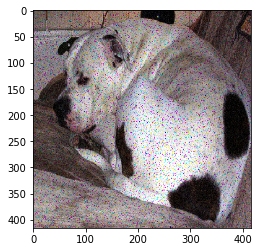

In [24]:
plt.imshow(result[0][0][num])

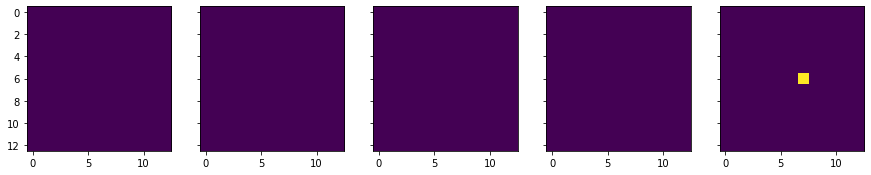

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(15, 10), sharey=True)
for i in range(5):
    axs[i].imshow(result[1][num][:,:,i,4]) # train_label
plt.show()

In [26]:
a = np.random.uniform(0,2,(16,13,13,5,1,2))
b = np.random.uniform(0,1,(16, 1, 1, 1,50,2))

In [27]:
a.shape

(16, 13, 13, 5, 1, 2)

In [28]:
num = 10

In [29]:
a[0].shape

(13, 13, 5, 1, 2)

In [30]:
a[0][num,0,3,0,0]

0.36488227720123456

In [31]:
b[0][0,0,0,0,0]

0.4489709982513246

In [32]:
b[0]

array([[[[[0.448971  , 0.67886352],
          [0.842112  , 0.58293998],
          [0.57564381, 0.208116  ],
          [0.18034895, 0.59233133],
          [0.71026447, 0.9620162 ],
          [0.485233  , 0.58168027],
          [0.50585721, 0.10698479],
          [0.33923329, 0.67888019],
          [0.77532971, 0.58849719],
          [0.63658049, 0.63062995],
          [0.34394894, 0.05040652],
          [0.16327045, 0.17284744],
          [0.84317721, 0.85899543],
          [0.9051634 , 0.53681863],
          [0.38662994, 0.06836375],
          [0.11375924, 0.96977619],
          [0.76200495, 0.55763626],
          [0.56134096, 0.01340588],
          [0.81671191, 0.82497314],
          [0.76303659, 0.86713186],
          [0.63603642, 0.54080747],
          [0.352034  , 0.84266918],
          [0.40492146, 0.48484451],
          [0.8296313 , 0.84846119],
          [0.56123791, 0.13410867],
          [0.69130288, 0.81089937],
          [0.57665409, 0.93374382],
          [0.26282977, 0.257

In [33]:
b[0][0,0,0,num,0]

0.3439489415449166

In [34]:
np.maximum([1,2,7],[[4,5,6],[3,2,1]])

array([[4, 5, 7],
       [3, 2, 7]])

In [35]:
tf.maximum(a,b)[0].shape

TensorShape([13, 13, 5, 50, 2])

In [36]:
tf.maximum(a,b)[0][num,0,3,1,0]

<tf.Tensor: shape=(), dtype=float64, numpy=0.8421120006749611>

In [37]:
num = 9

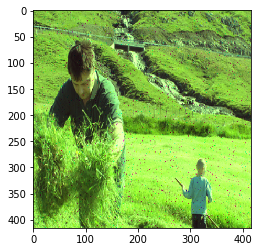

In [38]:
plt.imshow(result[0][0][num])

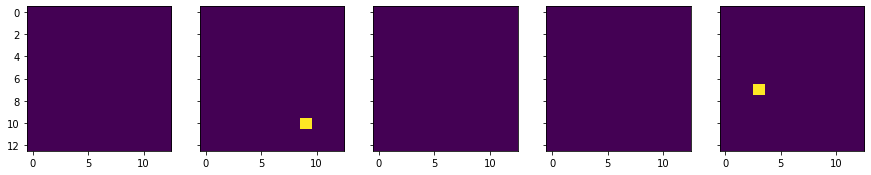

In [39]:
fig, axs = plt.subplots(1, 5, figsize=(15, 10), sharey=True)
for i in range(5):
    axs[i].imshow(result[1][num][:,:,:,4][:,:,i]) # train_label
plt.show()

In [40]:
true_boxes[num][0,0,0,:12,0]

array([9.765625, 3.171875, 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
      dtype=float32)

In [41]:
intersect_mins.shape

TensorShape([16, 13, 13, 5, 2])

In [42]:
intersect_areas.shape

TensorShape([16, 13, 13, 5])

In [43]:
coord_mask = tf.zeros(mask_shape)
conf_mask  = tf.zeros(mask_shape)
class_mask = tf.zeros(mask_shape)

In [44]:
### coordinate mask: simply the position of the ground truth boxes (the predictors)
coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE

### confidence mask: penelize predictors + penalize boxes with low IOU
# penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
true_xy = true_boxes[..., 0:2] # (16,1,1,1,50,2)
true_wh = true_boxes[..., 2:4] # (16,1,1,1,50,2)

true_wh_half = true_wh / 2.
true_mins    = true_xy - true_wh_half
true_maxes   = true_xy + true_wh_half 

pred_xy = tf.expand_dims(pred_box_xy, 4) #(16,13,13,5,1,2)
pred_wh = tf.expand_dims(pred_box_wh, 4)

pred_wh_half = pred_wh / 2.
pred_mins    = pred_xy - pred_wh_half
pred_maxes   = pred_xy + pred_wh_half    

intersect_mins  = tf.maximum(pred_mins,  true_mins)
intersect_maxes = tf.minimum(pred_maxes, true_maxes)
intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.) # 0 미만인 애들은 0으로 치환
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_wh[..., 0] * true_wh[..., 1]
pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

union_areas = pred_areas + true_areas - intersect_areas
iou_scores  = tf.truediv(intersect_areas, union_areas)

best_ious = tf.reduce_max(iou_scores, axis=4)
conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE # no_obj

# penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE # obj

### class mask: simply the position of the ground truth boxes (the predictors)
class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE 

### Finaliza the loss

In [45]:
coord_mask.shape

TensorShape([16, 13, 13, 5, 1])

In [46]:
nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0)) # batch의 활성화된 coord가 있는 개수
nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0)) # batch의 no_obj, obj가 있는 개수
nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0)) # batch의 할당화된 class가 있는 개수

In [47]:
loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)

In [9]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [10]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
______________________________________________________________________________________________

In [12]:
wt_path = './yolo.weights'

In [13]:
weight_reader = WeightReader(wt_path)

In [14]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [15]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

In [16]:
def custom_loss(y_true, y_pred):
    print("start")
    mask_shape = tf.shape(y_true)[:4]
    print("마스크")
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    print("쉘",cell_grid)
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    print("zero",coord_mask)

    
    print("hello1")
    
    """
    Adjust prediction
    """
    print("hello-section1")
    ### adjust x and y      
    print(tf.sigmoid(y_pred[..., :2]))
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    print("hello-section3")
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    print("hello-section")
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    print("hello2")
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    print("hello")
    
    return loss

In [17]:
train_imgs = all_imgs[:15008]
valid_imgs = all_imgs[15008:]

print("all_imgs:",len(all_imgs))
print("train_imgs:",len(train_imgs))
print("valid_imgs:",len(valid_imgs))

all_imgs: 17125
train_imgs: 15008
valid_imgs: 2117


In [18]:
train_batch = BatchGenerator(train_imgs,generator_config,norm=normalize)
valid_batch = BatchGenerator(valid_imgs,generator_config,norm=normalize)

In [19]:
len(valid_batch)

133

In [20]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_coco.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

In [21]:
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss='mse', optimizer=optimizer)

return 배치
(16, 416, 416, 3)


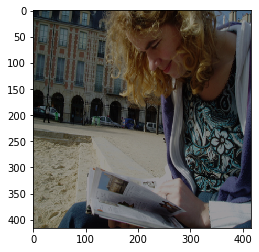

In [22]:
a = next(iter(train_batch))

In [23]:
a[0][1].shape

(16, 1, 1, 1, 50, 4)

In [24]:
b = np.concatenate((a[0][0],a[0][0]))

In [25]:
c = np.concatenate((a[0][1],a[0][1]))

In [26]:
d = np.concatenate((a[1],a[1]))

In [32]:
model.fit(x=[b,c],y=d,batch_size=16,)

Train on 32 samples
32/32 [==============================] - 16s 494ms/sample - loss: 0.0238


return 배치
(16, 416, 416, 3)


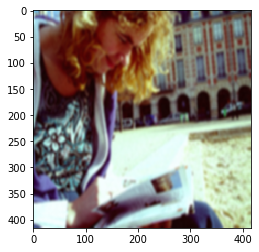

W1027 22:56:00.266304 4522552768 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 1 steps
return 배치
(16, 416, 416, 3)


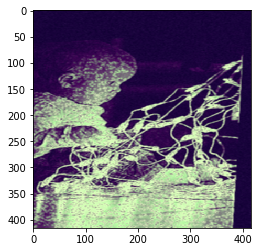

return 배치
(16, 416, 416, 3)


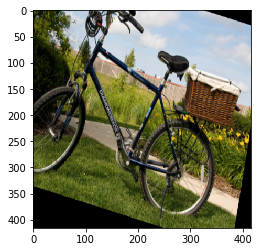

return 배치
(16, 416, 416, 3)


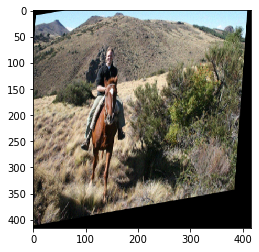

return 배치
(16, 416, 416, 3)


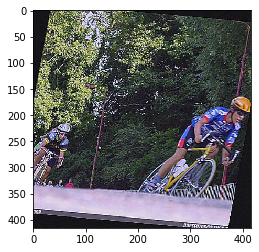

return 배치
(16, 416, 416, 3)


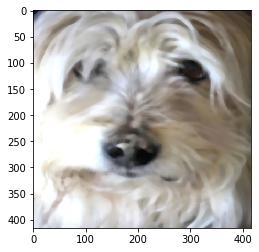

return 배치
(16, 416, 416, 3)


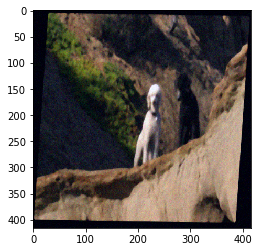

return 배치
(16, 416, 416, 3)


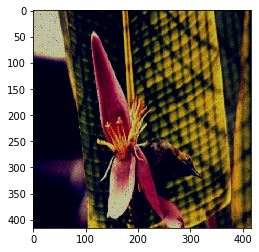

1/1 [==============================] - 9s 9s/step - loss: 0.0097
return 배치
(16, 416, 416, 3)


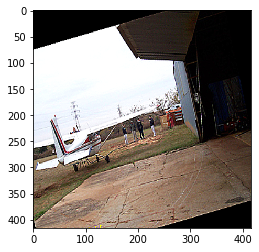

In [28]:
model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = 1, 
                    epochs           = 1, 
                    verbose          = 1)